In [167]:
# capture_pynq
# requires pynqserver to run on Pynq
# requires FOBOS Shield
# uses NewAE CW305 as DUT
import os
import sys
import shutil
#import binascii
#import time
import numpy as np
from foboslib import projmgr
from foboslib.ctrl import pynqctrl
from foboslib.ctrl.fobosctrl import FOBOSCtrl
from foboslib.fobosTVGen import FobosTVGen
#from foboslib.dut import nexys4dut

WORKSPACE       = "fobosworkspace"
PROJECT_NAME    = "aes"
DIN_FILE        = "dinFile.txt"
PLAIN_FILE      = "plaintext.txt"
CIPHER_FILE     = "ciphertext.txt"
KEY_FILE        = "key.txt"
TRACE_FILE      = "powerTraces.npy"
DUT_BIT_FILE    = "aes_cw305.bit"
OUT_LEN         = 16 # in bytes
TRACE_NUM       = 10000
SAMPLING_FREQ   = 100
DUT_CLK         = 1
SAMPLE_NUM      = 2000
ADC_GAIN        = 50
ADC_HILO        = 1 # 0 - low amplification, 1 - high amplification



In [168]:
### When running localy on Pynq
# overlay = Overlay("../fobos_ctrl.bit")
# ctrl = pynqctrl.PYNQCtrl(overlay)
# fobosAcq = openadc.OpenADCScope(overlay)

### When running remotely on Pynq
ctrl = pynqctrl.PYNQCtrl('192.168.2.99', 9995)

Acquired hardware lock


In [169]:
ctrl.setDUTClk(DUT_CLK)  # setting DUT clock resets all modules using this clock
ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)
ctrl.setDUT(FOBOSCtrl.CW305)
ctrl.setOutLen(OUT_LEN)
ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)
ctrl.setSamplingFrequency(SAMPLING_FREQ)
ctrl.setSamplesPerTrace(SAMPLE_NUM)
ctrl.setADCGain(ADC_GAIN)
ctrl.setADCHiLo(ADC_HILO)

0

In [161]:
from chipwhisperer.capture.targets.CW305 import CW305
cw = CW305()
cw.con(bsfile="/home/jkaps/projects/FOBOS/foboscompile/dutCW305/dutCW305/dutCW305.runs/impl_1/half_duplex_dut.bit", force=True)
cw.dis()

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


In [170]:
# Configure project directories
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(PROJECT_NAME)
projDir = pm.getProjDir()

In [171]:
# Generate test vectors
tvGen = FobosTVGen(traceNum=TRACE_NUM,
                   blockSize=16,
                   keySize=16,
                   cipherSize=16,
                   dinFile= os.path.join(projDir, DIN_FILE),
                   plaintextFile=os.path.join(projDir, PLAIN_FILE),
                   keyFile=os.path.join(projDir, KEY_FILE)
                   )
tvGen.generateTVs()

Generating 10000 test vectors...
    KeyFile = fobosworkspace/aes/key.txt
    PlaintextFile = fobosworkspace/aes/plaintext.txt
    Block Size (bytes) = 16
    Ciphertext Size (bytes) = 16
    Key Size (bytes)= 16
Done.


In [172]:
tvFileName = os.path.join(projDir, DIN_FILE)
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
plainFileName = os.path.join(projDir, PLAIN_FILE)
cipherFileName = os.path.join(captureDir, CIPHER_FILE)
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, TRACE_FILE)
traceFile = open(traceFileName, "a+b")
shutil.copy(tvFileName, captureDir)
shutil.copy(plainFileName, captureDir)

Successfully created new capture directory at fobosworkspace/aes/capture/attempt-18


'fobosworkspace/aes/capture/attempt-18/plaintext.txt'

In [173]:
print('Processing test vectors ...')
traceNum = 0
while traceNum < TRACE_NUM:
    data = tvFile.readline()
    status, result, trace = ctrl.processData2(data, OUT_LEN)
    cipherFile.write(result + "\n")
    np.save(traceFile, trace)
    if traceNum % 100 == 0:
        sys.stdout.write('Progress:' + "{:.2f}".format(traceNum/TRACE_NUM*100) + '%\r')
        sys.stdout.flush()
    traceNum += 1
print('Data acquisition complete.')
ctrl.disconnect() # release and reset control board.
traceFile.close()
cipherFile.close()
tvFile.close()

Processing test vectors ...
Data acquisition complete.
Released hardware lock.


<Figure size 432x288 with 0 Axes>

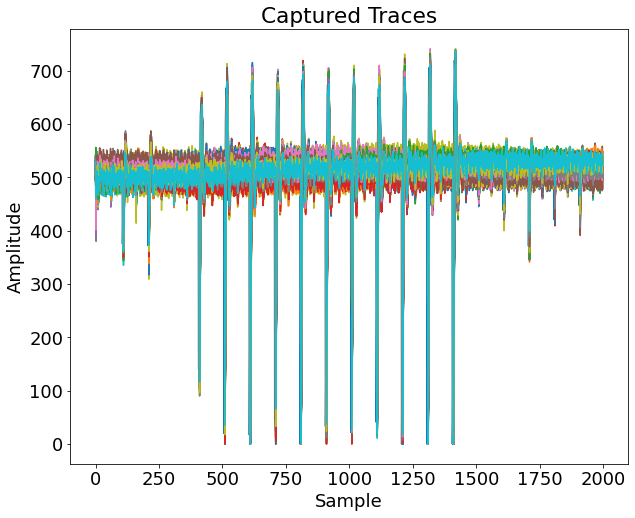

In [174]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 18})
traceFile = open(traceFileName, "r+b")
maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Captured Traces')
for i in range(min(maxtrace, TRACE_NUM)):
    trace = np.load(traceFile)
    plt.plot(trace)

plt.savefig(os.path.join(captureDir, 'traces.png'),facecolor=fig.get_facecolor())
# plt.close()
traceFile.close()

In [175]:
print(result)

80 61 a7 87 c3 d6 5b 2e 72 90 6c 38 dc 86 cf b2


In [176]:
import foboslib.cpa as cpa
import foboslib.traceset as traceset
import foboslib.powermodels.AESFirstLast as powermodel #code to calculate hypothetical power
import foboslib.powermodels.utils as powermodelUtils

In [180]:
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir("fobosworkspace/aes/capture")
pm.setProjName("attempt-18")
projDir = pm.getProjDir()
analysisDir = pm.getAnalysisDir()

Successfully created new analysis directory at fobosworkspace/aes/capture/attempt-18/analysis/attempt-01


In [181]:
HYPO_FILE = os.path.join(projDir, "hypotheticalPower.npy")
TRACES_FILE = os.path.join(projDir, TRACE_FILE)
PLAIN_TEXT = os.path.join(projDir, PLAIN_FILE)
CIPHER_TEXT = os.path.join(projDir, CIPHER_FILE)

#if os.path.isfile(HYPO_FILE):
    # already exists. load it
#    hypotheticalPower = powermodelUtils.loadHypoPower(HYPO_FILE)
#else:
    # not there. generate it
hypotheticalPower = powermodel.getHypotheticalPower(PLAIN_TEXT, CIPHER_TEXT, TRACE_NUM)
powermodelUtils.saveHypoPower(hypotheticalPower, HYPO_FILE)

powermodelUtils.showHypoPower(hypotheticalPower, plainFile=PLAIN_FILE, cipherFile=CIPHER_FILE)

---- Loading powermodel input data:
Plaintext :
Matrix shape is (10000, 16)
[[ac a 7f ... cc 21 d8]
 [43 b3 4e ... 7d e5 d8]
 [9 a4 74 ... d6 66 62]
 ...
 [95 e6 1b ... a4 73 7a]
 [79 33 5b ... 3c ff cd]
 [ea 41 31 ... bc 4d 9c]]

Ciphertext :
Matrix shape is (10000, 16)
[[6b 65 3 ... 90 6b 27]
 [83 9c b9 ... 78 b4 61]
 [92 24 64 ... d6 4c d8]
 ...
 [6b fc 5e ... d6 1 69]
 [81 ae 8a ... 2c 52 de]
 [80 61 a7 ... 86 cf b2]]

---- Loading powermodel input data complete.
---- Calculating hypothetical power for all subkeys:
---- Hypothetical power calculation done.
Saving hypthetical power to fobosworkspace/aes/capture/attempt-18/hypotheticalPower.npy.
saving done.
Power model :
Hypothetical power matrix for subkey 0:
Matrix shape is (10000, 256)
[[3 4 4 ... 4 0 6]
 [4 4 6 ... 4 2 3]
 [6 5 5 ... 4 2 5]
 ...
 [4 3 3 ... 2 6 2]
 [4 4 5 ... 1 3 5]
 [4 5 5 ... 6 6 4]]

Hypothetical power matrix for subkey 1:
Matrix shape is (10000, 256)
[[5 4 2 ... 3 7 5]
 [1 5 3 ... 3 5 3]
 [5 4 6 ... 3 2 6]
 

In [182]:
projDir

'fobosworkspace/aes/capture/attempt-18'

Loading raw traces from file: fobosworkspace/aes/capture/attempt-18/powerTraces.npy
Please wait ...
Loading done.
The shape of the traces matrix is (10000, 25)


<Figure size 432x288 with 0 Axes>

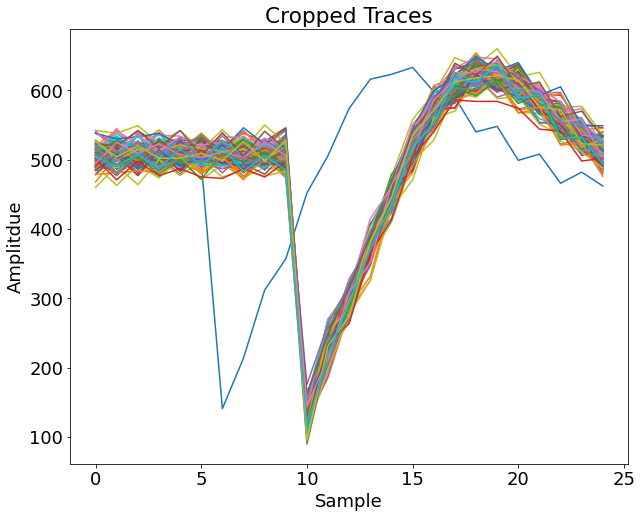

In [183]:
# load traces from file.
traceSet = traceset.TraceSet(traceNum=TRACE_NUM,
                            fileName=TRACES_FILE,
                            cropStart=400,
                            cropEnd=425)

measuredPower = traceSet.traces
print(f'The shape of the traces matrix is {measuredPower.shape}')


maxtrace = 100
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 18})
traceFile = open(traceFileName, "r+b")
maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitdue')
plt.title('Cropped Traces')
for i in range(min(maxtrace, TRACE_NUM)):
    plt.plot(measuredPower[i])
plt.savefig(os.path.join(analysisDir, 'cropped_traces.png'),facecolor=fig.get_facecolor())

In [184]:
numKeys = 16              # number of subkey bytes to attack, default: 1
#####################
# Run the attack
cpaAttacker = cpa.CPA()
C = cpaAttacker.doCPA(measuredPower=measuredPower,
                      hypotheticalPower=hypotheticalPower,
                      numTraces= TRACE_NUM,
                      analysisDir=analysisDir,
                      MTDStride= 100,
                      numKeys = numKeys,
                      plot= True, # enable/disable plots
                      plotSize=(10,8),
                      plotFontSize=18
                      )

Running CPA attack. Please wait ...
subkey number = 0, subkey value = 0x1, correlation = 0.04712603825700506, at sample = 10
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 1, subkey value = 0x23, correlation = 0.05574441558558284, at sample = 10
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 2, subkey value = 0x45, correlation = 0.05513540971863312, at sample = 10
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 3, subkey value = 0x54, correlation = 0.03555636219270973, at sample = 11
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 4, subkey value = 0x89, correlation = 0.05287493884420346, at sample = 11
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 5, subkey value = 0xab, correlation = 0.03927244189081701, at sample = 11
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 6, subkey value = 0xcd, correlation = 0.04858690104435248, at sample = 10